#### Build the best pipeline and best estimator  found for variable y=G1, on dataset with all variables and evaluate the performance metrics.

matplotlib, seaborn

In [1]:
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_style('darkgrid')
plt.rcParams['figure.dpi']=150 #resolution in dots per inch

numpy, pandas

In [2]:
import numpy as np
import pandas as pd

from numpy import asarray
from numpy import save
from numpy import load
from numpy import isnan

In [3]:
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
# MinMaxScaler() normalizes, range on the training set, default=(0, 1)

imputers

In [4]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.impute import KNNImputer

import miceforest as mf #multiple imputer

validation methods`

In [5]:
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

tensorflow

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import BatchNormalization

pipeline

In [7]:
from sklearn.pipeline import make_pipeline, Pipeline
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [8]:
#script, function for confusion matrix
%run -i show_confusion_matrix.py

In [9]:
import time
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#Cohen's kappa  because of class imbalance
from sklearn.metrics import cohen_kappa_score

In [10]:
#load data
data = pd.read_csv('data_all_vars.csv')
#make sure dataset has only numbers
data = data.apply(pd.to_numeric)
data.shape

(1838, 748)

In [11]:
#split to dependent and independent variables
X = data.loc[:, data.columns != 'G1'].values #select all but the desired G1 for y { 0 :'None', 1 :'Questionable', 2 :'Mild', 3 :'Moderate', 4 :'Severe'}
y = data['G1'].values

print(X.shape,y.shape)

(1838, 747) (1838,)


In [12]:
#split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10, shuffle=True, stratify=y)


In [13]:
# determine the number of input features for NN input layer
n_features = X.shape[1]

In [15]:
#model definition of best parameters found
def create_nn(activation = 'relu', 
              optimizer='adam', 
              init='he_normal', 
              layer1_units=32, 
              hidden_layers=1, 
              dropout_rate=0):
    # create model
    model = Sequential()
    
    # Add an input layer
    model.add(Dense(units=layer1_units, 
                    kernel_initializer=init, 
                    activation='relu', 
                    input_shape=(n_features,)))
    
    for i in range(hidden_layers): # Add hidden layer
        model.add(Dense(32, 
                    kernel_initializer=init, 
                    activation='relu'))
        
    model.add(Dropout(rate=dropout_rate))    
    # Add an output layer
    model.add(Dense(5, activation='softmax'))
       
    # Compile model
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['sparse_categorical_accuracy']) # 'sparse_categorical_accuracy' because of chosen loss metric
    
    return model
      


In [16]:
#wrap the model create function in KerasClassifier class so as to be able to use with grid search
model_wrap = KerasClassifier(build_fn=create_nn, 
                             activation = 'relu', 
                             optimizer='adam', 
                             init='he_normal', 
                             layer1_units=32, 
                             hidden_layers=3, 
                             dropout_rate=0.5,                             
                             batch_size=32, 
                             epochs=10, 
                             verbose=0)

In [17]:
#create a basic pipeline for scaling and imputation
pipeline_knn = Pipeline([
    ('scaler', MinMaxScaler()),
    ('imputer', KNNImputer()),
    ('model', model_wrap)])

In [18]:
#define all grid parameters to search over
param_grid ={
    'scaler': [MinMaxScaler()], 
    'imputer__n_neighbors' : [3],
    'model__activation' : ['relu'],
    'model__optimizer' : ['adam'],
    'model__init' : ['he_normal'], 
    'model__epochs' : [40],
    'model__batch_size' : [16],
    'model__hidden_layers' : [3], 
    'model__dropout_rate' : [0.5],
    'model__layer1_units' : [32]
    
}
grid_results = GridSearchCV(estimator=pipeline_knn, 
                    param_grid=param_grid, 
                    scoring='accuracy', 
                    cv = 10,
                    verbose=1,)

In [19]:
start_time = time.time()

#fit grid search on training data
grid_results.fit(X_train, y_train)

#calculate time for fit function
elapsed_time = time.time() - start_time
print(elapsed_time, "seconds for fitting gridsearch")

Fitting 10 folds for each of 1 candidates, totalling 10 fits
148.46967768669128 seconds for fitting gridsearch


In [20]:
print('Parameters :\n %s' % grid_results.best_params_)
# Best training data accuracy
print('\nBest training score: %.3f' % grid_results.best_score_)
# Predict on test data with best params
y_pred = grid_results.predict(X_test)
# Test data accuracy of model with best params
print('\nTest set accuracy score: %.3f ' % accuracy_score(y_test, y_pred))

Parameters :
 {'imputer__n_neighbors': 3, 'model__activation': 'relu', 'model__batch_size': 16, 'model__dropout_rate': 0.5, 'model__epochs': 40, 'model__hidden_layers': 3, 'model__init': 'he_normal', 'model__layer1_units': 32, 'model__optimizer': 'adam', 'scaler': MinMaxScaler()}

Best training score: 0.896

Test set accuracy score: 0.916 


In [23]:
#evaluation metrics on test set predictions
print('\n',confusion_matrix(y_test, y_pred))
print('\n',classification_report(y_test, y_pred))
print('\n Cohen\'s kappa: ',cohen_kappa_score(y_test, y_pred))


 [[296   7   0   0   0]
 [ 13  35   0   0   0]
 [  1   4   5   2   0]
 [  0   0   2   0   1]
 [  0   0   0   1   1]]

               precision    recall  f1-score   support

         0.0       0.95      0.98      0.97       303
         1.0       0.76      0.73      0.74        48
         2.0       0.71      0.42      0.53        12
         3.0       0.00      0.00      0.00         3
         4.0       0.50      0.50      0.50         2

    accuracy                           0.92       368
   macro avg       0.59      0.52      0.55       368
weighted avg       0.91      0.92      0.91       368


 Cohen's kappa:  0.7088979050243691


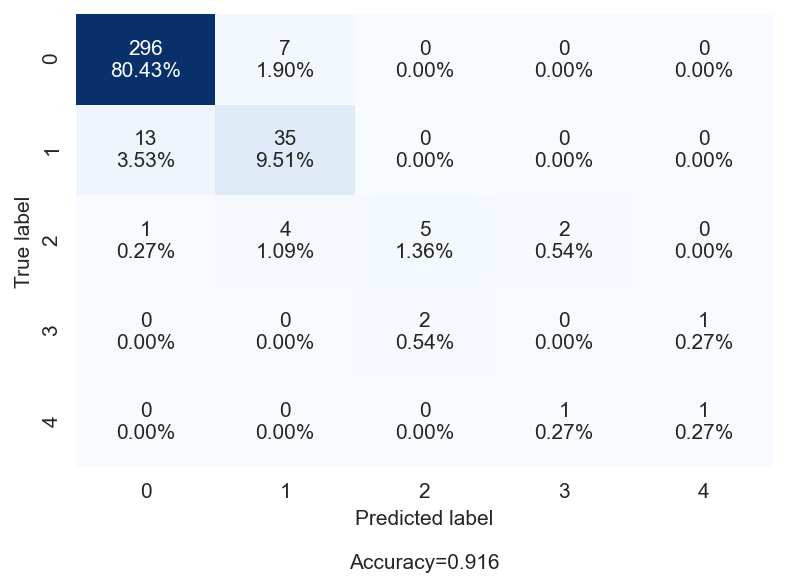

In [24]:
cf_matrix = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cf_matrix, figsize=(6,4), cbar=False)

In [25]:
#extract results to put on a dataframe
means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']

# we can get the metrics on the train set as well provided you set return_train_score = True
# However computing the scores on the training set can be computationally expensive

In [27]:
d=pd.DataFrame(params)
d['Mean']=means
d['Std. Dev']=stds
d.to_csv(r'C:\Users\redi\Desktop\Βαρλαμης\data\G1_all_df.csv',index=False, float_format='%.4f')
d

,imputer__n_neighbors,model__activation,model__batch_size,model__dropout_rate,model__epochs,model__hidden_layers,model__init,model__layer1_units,model__optimizer,scaler,Mean,Std. Dev
0,3,relu,16,0.5,40,3,he_normal,32,adam,MinMaxScaler(),0.895918,0.015227


In [29]:
#save cv split results
df_result = pd.DataFrame(grid_results.cv_results_)
#save df to file
df_result.to_csv(r'C:\Users\redi\Desktop\Βαρλαμης\data\G1_all_cv_splits.csv',index=False, float_format='%.4f')
df_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_imputer__n_neighbors,param_model__activation,param_model__batch_size,param_model__dropout_rate,param_model__epochs,param_model__hidden_layers,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,12.673241,0.937758,0.794039,0.110881,3,relu,16,0.5,40,3,...,0.904762,0.884354,0.897959,0.911565,0.897959,0.870748,0.897959,0.895918,0.015227,1
